**Mask-RCNN Starter Model for the RSNA Pneumonia Detection Challenge with transfer learning **

Using pre-trained COCO weights trained on http://cocodataset.org as in https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon

We get the best public kernel performance so far, and also training only within the 6hrs kaggle limit.

In [0]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q imgaug 
!pip3 install -q kaggle
!pip3 install -q tqdm 

In [2]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import keras
import glob 

Using TensorFlow backend.


In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
    file_metadata = {
      'name': name,
      'mimeType': 'application/octet-stream'
     }
  
    media = MediaFileUpload(path, 
                    mimetype='application/octet-stream',
                    resumable=True)

    created = drive_service.files().create(body=file_metadata,
                                   media_body=media,
                                   fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created

In [0]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="skooch"
os.environ['KAGGLE_KEY']="42f8a02ee92cc773d1dbe66565673ad3"

In [5]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

Updated property [core/project].


In [0]:
# If you are unable to download the competition dataset, check to see if you have 
# accepted the user agreement on the competition website. 
if not os.path.exists("./stage_1_detailed_class_info.csv.zip"):
    !kaggle competitions download -c rsna-pneumonia-detection-challenge

In [0]:
# unzipping takes a few minutes
if not os.path.exists("./stage_1_train_labels.csv"):
    print("Unzipping...")
    !unzip -q -o stage_1_test_images.zip -d stage_1_test_images
    !unzip -q -o stage_1_train_images.zip -d stage_1_train_images
    !unzip -q -o stage_1_train_labels.csv.zip

In [0]:
DATA_DIR = '/content'

# Directory to save logs and trained model
ROOT_DIR = '/content/working'

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [9]:
!git clone https://www.github.com/escuccim/Mask_RCNN.git
os.chdir('Mask_RCNN')

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [0]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [0]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_1_test_images')

### Download COCO pre-trained weights

In [12]:
# !wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
# !ls -lh mask_rcnn_coco.h5

# COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"


Redirecting output to ‘wget-log.3’.
-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [0]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [14]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 12
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    RPN_ANCHOR_SCALES = (48, 96, 192, 384)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 500
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     12
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 12
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES 

In [0]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [16]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_1_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [0]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [0]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets

In [20]:
# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

24184 1500


### Create and prepare the training dataset using the DetectorDataset class.

In [0]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display a random image with bounding boxes

(1024, 1024, 3)
/content/stage_1_train_images/f88e605a-a637-4df6-a153-5c51bb304a73.dcm
[1 1]


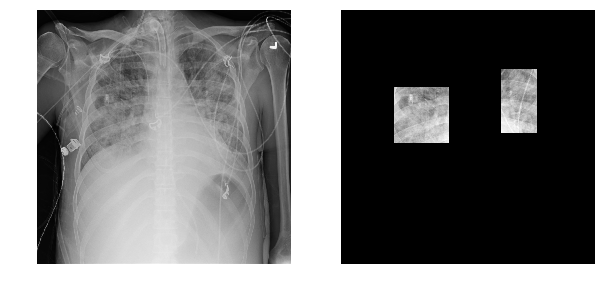

In [22]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
  masked += image[:, :, 0] * mask[:, :, i]
  
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

### Image Augmentation. Try finetuning some variables to custom values

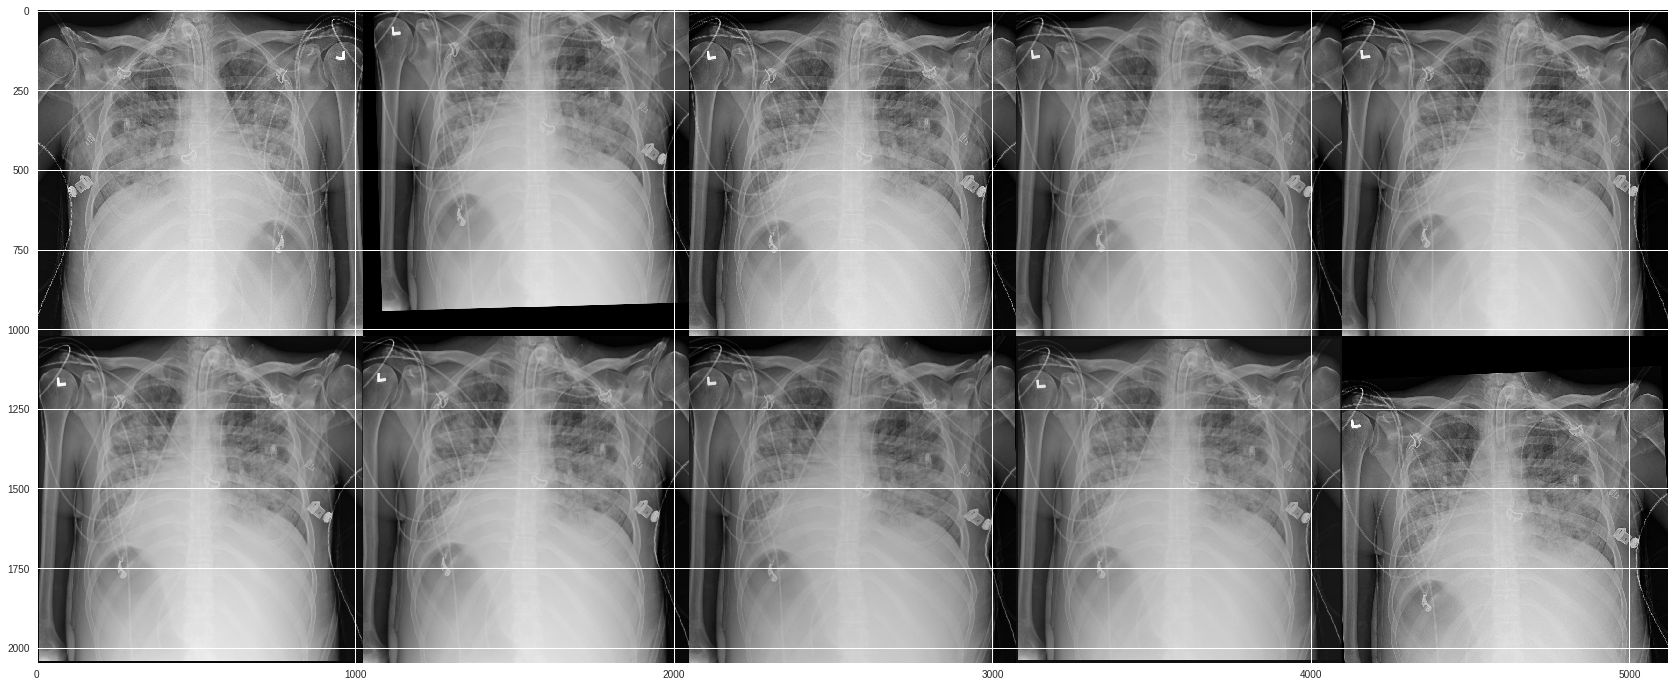

In [23]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            rotate=(-3, 3),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
        iaa.Crop(px=(0, 5)),
        iaa.Pad(px=(0, 16)),
        iaa.Noop(),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.85, 1.15)),
        iaa.Add((-15, 15)),
        iaa.Noop(),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.5)),
        iaa.Sharpen(alpha=(0.0, 0.4)),
        iaa.Noop(),
    ]),
    # flip left/right 50% of time
    iaa.Fliplr(0.5),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

### Download the latest checkpoint to resume training

In [24]:
file_name = "Copy_mask_rcnn_pneumonia_0005.h5"
!gsutil cp gs://{bucket_name}/{file_name} /content/working/pneumonia/{file_name}

Copying gs://pneumonia/Copy_mask_rcnn_pneumonia_0005.h5...
/ [1 files][170.9 MiB/170.9 MiB]                                                
Operation completed over 1 objects/170.9 MiB.                                    


### Now it's time to train the model. Note that training even a basic model can take a few hours. 

Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time. 

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [0]:
class upload_checkpoint(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        last_checkpoint = model.find_last()

        # upload checkpoint to GCS
        project_id = 'mammography-198911'
        bucket_name = 'pneumonia'

        !gcloud config set project {project_id}
        !gsutil cp {last_checkpoint} gs://{bucket_name}/mask_rcnn_pneumonia_0005.h5
        
        return

In [26]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

upload_file_cb = upload_checkpoint()

# Exclude the last layers because they require a matching
# number of classes
# model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
#     "mrcnn_class_logits", "mrcnn_bbox_fc",
#     "mrcnn_bbox", "mrcnn_mask"])

# checkpoint = model.find_last()
checkpoint = "/content/working/pneumonia/Copy_mask_rcnn_pneumonia_0005.h5"
print("Loading weights from:", checkpoint)

# load the previous weights
model.load_weights(checkpoint)
# set the current epoch 
model.epoch = 5

LEARNING_RATE = 0.004

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

Loading weights from: /content/working/pneumonia/Copy_mask_rcnn_pneumonia_0005.h5


In [28]:
import tensorflow as tf
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print("TPU:", TPU_WORKER)

# create network and compiler
model2 = tf.contrib.tpu.keras_to_tpu_model(
model.keras_model, strategy=tf.contrib.tpu.TPUDistributionStrategy(
    tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

model.keras_model = model2

TPU: grpc://10.81.174.194:8470
INFO:tensorflow:Querying Tensorflow master (b'grpc://10.81.174.194:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 14774829366913959483)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 12763678816225300188)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 12835906650858537286)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6615771359846251685)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 18275954173316147726)
INFO:tensor

ValueError: ignored

In [40]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=6,
            layers='heads',
            augmentation=None)  ## no need to augment yet


Starting at epoch 0. LR=0.004

Checkpoint Path: /content/working/pneumonia/mask_rcnn_pneumonia_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 1/6


InvalidArgumentError: ignored

In [38]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/2,
            epochs=8,
            layers='5+',
            augmentation=augmentation)


Starting at epoch 5. LR=0.002

Checkpoint Path: /content/working/pneumonia/mask_rcnn_pneumonia_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 6/8


InvalidArgumentError: ignored

In [69]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/6,
            epochs=23,
            layers='5+',
            augmentation=augmentation, custom_callbacks=[upload_file_cb])


Starting at epoch 22. LR=0.0006666666666666666

Checkpoint Path: /content/working/pneumonia/mask_rcnn_pneumonia_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 23/23
500/500 [==============================] - 4697s 9s/step - loss: 1.0043 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.1855 - mrcnn_class_loss: 0.1821 - mrcnn_bbox_loss: 0.2851 - mrcnn_mask_loss: 0.3387 - val_loss: 0.9687 - val_rpn_class_loss: 0.0129 - val_rpn_bbox_loss: 0.1879 - val_mrcnn_class_loss: 0.1625 - val_mrcnn_bbox_loss: 0.2751 - val_mrcnn_mask_loss: 0.3302

Epoch 00023: saving model to /content/working/pneumonia/mask_rcnn_pneumonia_0023.h5
Updated property [core/project].
Copying file:///content/working/pneumonia/mask_rcnn_pneumonia_0023.h5 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads.

In [28]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/8,
            epochs=24,
            layers='4+',
            augmentation=augmentation, custom_callbacks=[upload_file_cb])


Starting at epoch 20. LR=0.004

Checkpoint Path: /content/working/pneumonia/mask_rcnn_pneumonia_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 21/22
500/500 [==============================] - 4688s 9s/step - loss: 1.1461 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.2306 - mrcnn_class_loss: 0.2215 - mrcnn_bbox_loss: 0.3243 - mrcnn_mask_loss: 0.3521 - val_loss: 1.1567 - val_rpn_class_loss: 0.0191 - val_rpn_bbox_loss: 0.2552 - val_mrcnn_class_loss: 0.2303 - val_mrcnn_bbox_loss: 0.3120 - val_mrcnn_mask_loss: 0.3400

Epoch 00021: saving model to /content/working/pneumonia/mask_rcnn_pneumonia_0021.h5
Updated property [core/project].
Copying file:///content/working/pneumonia/mask_rcnn_pneumonia_0021.h5 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature ca

In [70]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /content/working/pneumonia/mask_rcnn_pneumonia_0023.h5


In [71]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# model_path = "/content/working/pneumonia/mask_rcnn_pneumonia_0018.h5"

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/working/pneumonia/mask_rcnn_pneumonia_0023.h5


In [0]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### How does the predicted box compared to the expected value? Let's use the validation dataset to check. 

Note that we trained only one epoch for **demonstration purposes ONLY**. You might be able to improve performance running more epochs. 

In [0]:
# calculate IOU where there can be multiple overlapping truths and predictions
def calc_iou_better(y_true, y_pred, image_size=1024):
    label_array = np.zeros((image_size, image_size))
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    for truth in y_true:
        x,y,w,h = truth[:4].astype(int)  
        label_array[y:y+h, x:x+w] = 1
                
    pred_array = np.zeros((image_size, image_size))
    for pred in y_pred:
        x,y,w,h = pred[:4].astype(int)

        # update the pixels
        pred_array[y:y+h, x:x+w] = 1
                
    true_area = np.sum(label_array)
    pred_area = np.sum(pred_array)
    
    intersect_area = np.sum((pred_array == 1) & (label_array == 1))
    
    union = true_area + pred_area - intersect_area
    
    iou = intersect_area / (union + 1e-6)
    
    return iou   

(384, 384, 3)


AttributeError: ignored

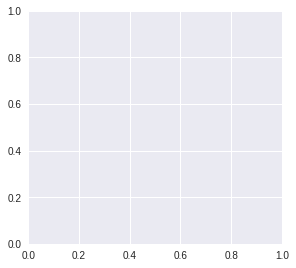

In [74]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))
iou_scores = []

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image])
    r = results[0]
    
    if len(r['rois']) or len(gt_bbox):
      iou = calc_iou_better(gt_bbox, r['rois'], 384)
      iou_scores.append(iou)
    
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
    
print("Mean IOU:", np.mean(iou_scores))   

In [0]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

### Final steps - Create the submission file

In [0]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [77]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 1000/1000 [04:11<00:00,  4.15it/s]

/content/working/submission.csv


In [78]:
!kaggle competitions submit -c rsna-pneumonia-detection-challenge -f {submission_fp} -m "mask-rcnn 384x384 23 epochs"

Successfully submitted to RSNA Pneumonia Detection Challenge

112bbb1f-9e2a-4421-b276-39868ef35904
[219  76 295 144]
x 202 y 584 h 182 w 202
[208 242 294 334]
x 645 y 554 h 245 w 230
0550968f-5ad7-460c-96c5-c2702535e344
[140  90 235 187]
x 240 y 373 h 258 w 253
[201 258 337 337]
x 688 y 536 h 210 w 362
0f6ed027-8700-43ff-a4a6-a8211cbbbb02
[140  64 286 158]
x 170 y 373 h 251 w 389
[212 204 328 289]
x 544 y 565 h 226 w 309
02363fdb-4cd0-4631-b3d8-7a10fddffa28
[235  51 317 138]
x 136 y 626 h 232 w 219
[225 203 334 318]
x 541 y 600 h 307 w 290


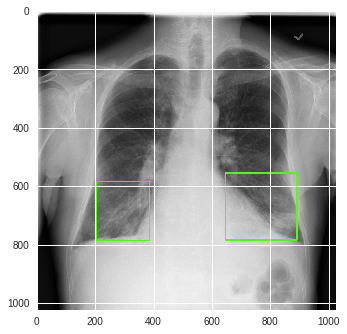

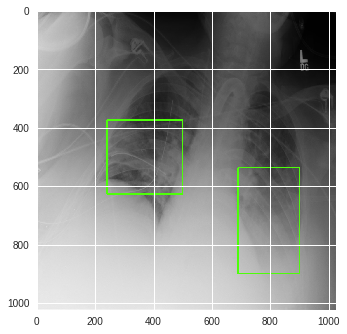

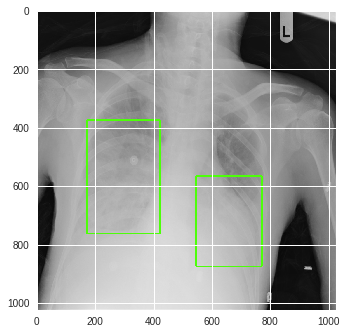

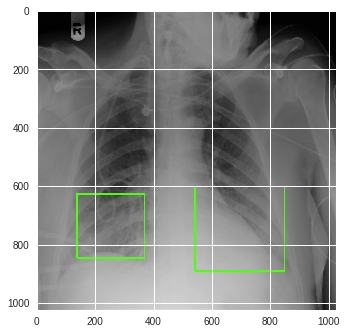

In [79]:
# show a few test image detection example
def visualize2(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize2()
visualize2()
visualize2()
visualize2()

In [80]:
last_checkpoint = model.find_last()
print(last_checkpoint)

# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
!gsutil cp {last_checkpoint} gs://{bucket_name}/

/content/working/pneumonia/mask_rcnn_pneumonia_0023.h5
Updated property [core/project].
Copying file:///content/working/pneumonia/mask_rcnn_pneumonia_0023.h5 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/170.9 MiB.                                    


In [81]:
last_checkpoint = "/content/working/pneumonia/mask_rcnn_pneumonia_0018.h5"
!gsutil cp {last_checkpoint} gs://{bucket_name}/

Copying file:///content/working/pneumonia/mask_rcnn_pneumonia_0018.h5 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/170.9 MiB.                                    
